In [140]:
# Code for data by individual incident number

import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import csv
from api_keys import g_key

In [141]:

csvpath = "Resources/sfpd_incidents_2016.csv"
sfpd_df = pd.read_csv(csvpath)
sfpd_clean = sfpd_df.loc[sfpd_df['Category']!= 'NON-CRIMINAL']
sfpd_clean_df = sfpd_clean.dropna(how='any')
sfpd_rawdata_clean = sfpd_clean_df.drop(['PdId'], axis = 1)
sfpd_incnum = sfpd_rawdata_clean.drop_duplicates(subset = "IncidntNum")
sfpd_incnum

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location
0,120058272,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)"
2,141059263,WARRANTS,WARRANT ARREST,Monday,04/25/2016 12:00:00 AM,14:59,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)"
5,160002869,ASSAULT,BATTERY,Friday,01/01/2016 12:00:00 AM,21:35,NORTHERN,NONE,1700 Block of BUSH ST,-122.426077,37.788019,"(37.788018555829, -122.426077177375)"
6,160003130,OTHER OFFENSES,PAROLE VIOLATION,Saturday,01/02/2016 12:00:00 AM,00:04,SOUTHERN,"ARREST, BOOKED",MARY ST / HOWARD ST,-122.405721,37.780879,"(37.7808789360214, -122.405721454567)"
8,160003970,WARRANTS,WARRANT ARREST,Saturday,01/02/2016 12:00:00 AM,12:21,SOUTHERN,"ARREST, BOOKED",4TH ST / BERRY ST,-122.393357,37.775788,"(37.7757876218293, -122.393357241451)"
...,...,...,...,...,...,...,...,...,...,...,...,...
150493,160858327,ASSAULT,BATTERY,Friday,10/21/2016 12:00:00 AM,13:30,MISSION,NONE,3400 Block of 18TH ST,-122.419749,37.761867,"(37.7618672648972, -122.419748993977)"
150495,161061000,ASSAULT,BATTERY,Friday,12/30/2016 12:00:00 AM,21:01,PARK,NONE,OAK ST / STANYAN ST,-122.453982,37.771428,"(37.7714278595913, -122.453981622365)"
150497,176000758,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Thursday,12/29/2016 12:00:00 AM,20:00,CENTRAL,NONE,PINE ST / TAYLOR ST,-122.412269,37.790673,"(37.7906727649886, -122.41226909106)"
150498,176000764,LARCENY/THEFT,GRAND THEFT OF PROPERTY,Friday,12/30/2016 12:00:00 AM,10:00,CENTRAL,NONE,200 Block of STOCKTON ST,-122.406659,37.788275,"(37.7882745285785, -122.406658711008)"


In [136]:
#sfpd_incnum["Category"].value_counts()

In [142]:
sf_crime_2_df = sfpd_incnum.loc[ :, ["IncidntNum", "Address"]]
sf_crime_2_df.head()

,IncidntNum,Address
0,120058272,800 Block of BRYANT ST
2,141059263,KEITH ST / SHAFTER AV
5,160002869,1700 Block of BUSH ST
6,160003130,MARY ST / HOWARD ST
8,160003970,4TH ST / BERRY ST


In [143]:
sf_crime_2_df["Address"].value_counts().head(15)

800 Block of BRYANT ST          2556
800 Block of MARKET ST           934
1000 Block of POTRERO AV         418
900 Block of MARKET ST           360
500 Block of JOHNFKENNEDY DR     359
3200 Block of 20TH AV            319
800 Block of MISSION ST          287
1000 Block of POINTLOBOS AV      278
1100 Block of FILLMORE ST        258
100 Block of OFARRELL ST         251
700 Block of MARKET ST           224
2000 Block of MARKET ST          223
0 Block of UNITEDNATIONS PZ      220
700 Block of MISSION ST          201
16TH ST / MISSION ST             200
Name: Address, dtype: int64

In [144]:
data = {'Region': ['800 Block of BRYANT ST', '800 Block of MARKET ST', '1000 Block of POTRERO AV',
                   '900 Block of MARKET ST', '500 Block of JOHNFKENNEDY DR', '3200 Block of 20TH AV',
                   '800 Block of MISSION ST', '1000 Block of POINTLOBOS AV', '1100 Block of FILLMORE ST',
                   '100 Block of OFARRELL ST', '700 Block of MARKET ST', '2000 Block of MARKET ST',
                   '0 Block of UNITEDNATIONS PZ', '700 Block of MISSION ST', '16TH ST / MISSION ST'], 
        'IncidentNum': [2556, 934, 418, 360, 359, 319, 287, 278, 258, 251, 224, 223, 220, 201, 200] 
} 
  
# Convert the dictionary into DataFrame 
region_df = pd.DataFrame(data)
region_df = region_df.set_index("Region")

# Observe the result 
region_df.head()

,IncidentNum
Region,
800 Block of BRYANT ST,2556
800 Block of MARKET ST,934
1000 Block of POTRERO AV,418
900 Block of MARKET ST,360
500 Block of JOHNFKENNEDY DR,359


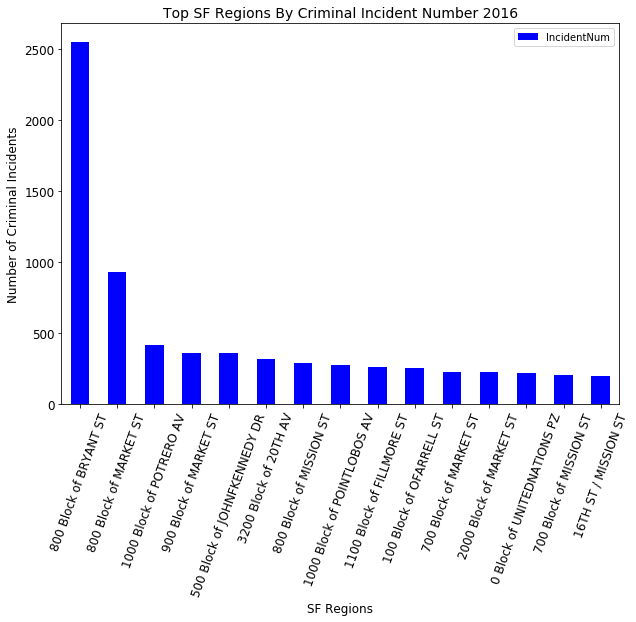

<Figure size 432x288 with 0 Axes>

In [145]:
crimes_reg_plot = region_df.plot.bar(figsize=(10,7), color='b',fontsize = 12) 

# Set the xlabel and ylabel using class methods
crimes_reg_plot.set_xlabel("SF Regions",fontsize = 12)
crimes_reg_plot.set_ylabel("Number of Criminal Incidents",fontsize = 12)
plt.title("Top SF Regions By Criminal Incident Number 2016",fontsize = 14)
plt.xticks(rotation = 70)
plt.show()
plt.tight_layout()

In [146]:
crime_dis_df = sfpd_incnum.groupby("PdDistrict")

count_crimes = crime_dis_df["PdDistrict"].count()

count_crimes

PdDistrict
BAYVIEW        9894
CENTRAL       12493
INGLESIDE      7725
MISSION       12662
NORTHERN      14340
PARK           5820
RICHMOND       6323
SOUTHERN      19427
TARAVAL        7688
TENDERLOIN     5904
Name: PdDistrict, dtype: int64

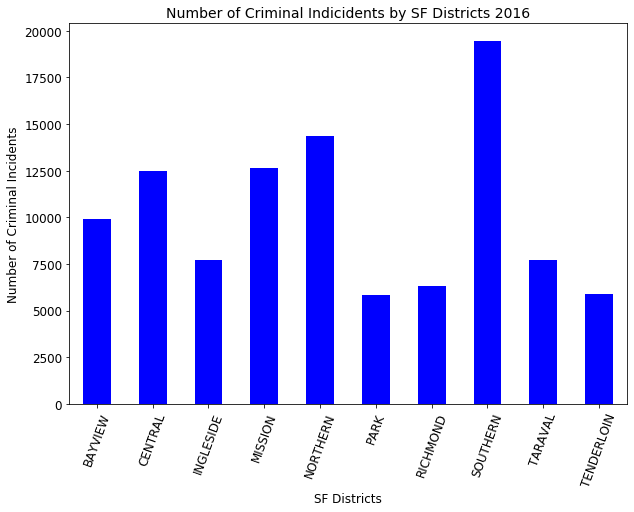

<Figure size 432x288 with 0 Axes>

In [147]:
crimes_plot = count_crimes.plot.bar(figsize=(10,7), color='b',fontsize = 12) 

# Set the xlabel and ylabel using class methods
crimes_plot.set_xlabel("SF Districts",fontsize = 12)
crimes_plot.set_ylabel("Number of Criminal Incidents",fontsize = 12)
plt.title("Number of Criminal Indicidents by SF Districts 2016",fontsize = 14)
plt.xticks(rotation = 70)
plt.show()
plt.tight_layout()

In [83]:
locations = sfpd_incnum[['Y', 'X']]
IncidntNum = sfpd_incnum['IncidntNum']
fig = gmaps.figure(center=(46.0, -5.0), zoom_level=2)
fig = gmaps.figure(layout={'width': '800px', 'height': '600px'})
heat_layer = gmaps.heatmap_layer(locations, weights=IncidntNum,dissipating=False, max_intensity=300, 
                                 point_radius=5)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='600px', width='800px'))

In [84]:
info_box_template = """
<dl>
<dt>Name</dt><dd>{IncidntNum}</dd>
<dt>City</dt><dd>{PdDistrict}</dd>
#<dt>Country</dt><dd>{IncidntNum}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
Incidents = [info_box_template.format(**row) for index, row in sfpd_incnum.iterrows()]
locations = sfpd_incnum[["X", "Y"]]

In [93]:
marker_layer = gmaps.marker_layer(locations, info_box_content=IncidntNum)
fig.add_layer(marker_layer)
# Display figure
fig

KeyError: 1